# Import Library

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import norm

N = norm.cdf

# **General Option Class**

In [2]:
class Option:

    def __init__(self, spot: float, strike: float, maturity: float, risk_free_rate: float, dividend: float,
                 volatility: float, option_type: str, side: str):
        self.spot = spot
        self.strike = strike
        self.mat = maturity
        self.rate = risk_free_rate
        self.div = dividend
        self.vol = volatility
        self.type = option_type
        self.side = side

# Option Pricing with Black-Scholes Model

**Assumption from Black-Scholes Model:**
* No dividends are paid out during the life of the option
* Markets are random 
* No transaction costs when buying the option
* Risk-Free Rate and volatility of underlying asset are known and constant
* Returns of underlying asset are normally distributed
* Option is European

In [3]:
class BS_Option_Pricing(Option):

    def __init__(self, spot, strike, maturity, rate, vol, option_type, side, dividend: float = None):
        Option.__init__(self, spot, strike, maturity, rate, dividend, vol, option_type, side)

    def d1(self, add_vol: int = None):
        vol = add_vol if add_vol else self.vol
        return (np.log((np.exp(-self.div * self.mat) if self.div else 1) * self.spot / self.strike)
                + (self.rate + vol ** 2 / 2) * self.mat) / (vol * np.sqrt(self.mat))

    def d2(self, add_vol: int = None):
        vol = add_vol if add_vol else self.vol
        return self.d1() - vol * np.sqrt(self.mat)

    def call_price(self, add_vol: int = None):
        return self.spot * norm.cdf(self.d1(add_vol)) * (np.exp(- self.div * self.mat) if self.div else 1) - \
               self.strike * np.exp(-self.rate * self.mat) * norm.cdf(self.d2(add_vol))

    def put_price(self, add_vol: int = None):
        return self.strike * np.exp(-self.rate * self.mat) * norm.cdf(-self.d2(add_vol)) - self.spot * norm.cdf(
            -self.d1(add_vol) * (np.exp(- self.div * self.mat) if self.div else 1))

    def call_implied_vol(self, target_price: int, tol: int = .001):
        sigma = tol
        while sigma < 1:
            temp_price = self.call_price(sigma)
            if abs(target_price - temp_price) < tol:
                return sigma
            else:
                sigma += tol
        return "Error when solving!"

    def put_implied_vol(self, target_price: int, tol: int = .001):
        sigma = tol
        while sigma < 1:
            temp_price = self.put_price(sigma)
            if abs(target_price - temp_price) < tol:
                return sigma
            else:
                sigma += tol
        return "Error when solving!"

# Greek from Option Study

In [4]:
class Greek(BS_Option_Pricing):

    def __init__(self, spot, strike, maturity, rate, vol, option_type, side, dividend: float = None):
        BS_Option_Pricing.__init__(self, spot, strike, maturity, rate, vol, option_type, side, dividend)

    def call_delta(self):
        return norm.cdf(self.d1())

    def put_delta(self):
        return -norm.cdf(-self.d1())

    def call_gamma(self):
        return norm.pdf(self.d1()) / (self.spot * self.vol * sqrt(self.mat))

    def put_gamma(self):
        return self.call_gamma()

    def call_vega(self):
        return self.spot * np.sqrt(self.mat) * norm.pdf(self.d1())

    def put_vega(self):
        return self.call_vega()

    def call_theta(self):
        return - ((self.spot * norm.pdf(self.d1()) * self.vol) / (
                2 * self.mat)) - self.rate * self.strike * np.exp(
            - self.rate * self.mat) * norm.cdf(self.d2())

    def put_theta(self):
        return - ((self.spot * norm.pdf(self.d1()) * self.vol) / (
                2 * self.mat)) + self.rate * self.strike * np.exp(
            - self.rate * self.mat) * norm.cdf(self.d2())

    def call_rho(self):
        return self.strike * self.mat * np.exp(- self.rate * self.mat) * norm.cdf(self.d2())

    def put_rho(self):
        return self.strike * self.mat * np.exp(- self.rate * self.mat) * norm.cdf(self.d2())

    "ADD EXOTIC GREEKS?"

    def get_details(self, kind: str):
        full_info = {
            "Option Price": round(self.call_price(), 3) if kind == "call" else round(self.put_price(), 3),
            "Option Delta": round(self.call_delta(), 3) if kind == "call" else round(self.put_delta(), 3),
            "Option Gamma": round(self.call_gamma(), 3) if kind == "call" else round(self.put_gamma(), 3),
            "Option Vega": round(self.call_vega(), 3) if kind == "call" else round(self.put_vega(), 3),
            "Option Theta": round(self.call_theta(), 3) if kind == "call" else round(self.put_theta(), 3),
            "Option Rho": round(self.call_rho(), 3) if kind == "call" else round(self.put_rho(), 3)
        }
        return full_info

# Main strategies payoff overview

In [5]:
class Strategies_payoffs(BS_Option_Pricing):

    def __init__(self, market_param: list, closing: float):
        BS_Option_Pricing.__init__(self, market_param[0], market_param[1], market_param[2], market_param[3],
                                   market_param[4], market_param[5], market_param[6], market_param[7])
        self.closing = closing

    def simple_option(self, option_type: str = "put", kind: str = "short"):
        premium = BS_Option_Pricing.put_price(self) if option_type == "put" else BS_Option_Pricing.call_price(self)
        multi = -1 if kind == "short" else 1
        payoff = multi * ((max(self.closing - self.strike, 0) if option_type == "call" else max(
            self.strike - self.closing, 0)) - premium)
        return payoff

    def bull_spread(self, kind: str, market_param2: list):
        return self.simple_option(kind, "long") + \
               Strategies_payoffs(market_param2, self.closing).simple_option(kind, "short")

    def straddle(self, kind: str = "short"):
        abs_payoff = self.simple_option("put", kind) + self.simple_option("call", kind)
        return abs_payoff

    def strangle(self, market_param2: list, kind: str = "short"):
        if not (self.strike < market_param2[1]):
            print("Second Option should have strike price lower than first one!")
            pass
        else:
            product_two = Strategies_payoffs(market_param2, self.closing)
            abs_payoff = self.simple_option("put", kind) + product_two.simple_option("call", kind)
            return abs_payoff

    def butterfly(self, market_param2: list, market_param3: list, kind: str = "short"):
        if (self.strike < market_param2[1] < market_param3[1]):
            option = "call"
        else:
            option = "put"

        product2 = Strategies_payoffs(market_param2, self.closing)
        product3 = Strategies_payoffs(market_param3, self.closing)
        if kind == "long":
            abs_payoff = self.simple_option(option, "long") + 2 * product2.simple_option(option, "short") \
                         + product3.simple_option(option, "long")

        else:
            abs_payoff = self.simple_option(option, "short") + 2 * product2.simple_option(option, "long") \
                         + product3.simple_option(option, "short")
        return abs_payoff

    def condor(self, market_param2: list, market_param3: list, market_param4: list, kind: str = "short"):
        if not (self.strike < market_param2[1] < market_param3[1] < market_param4[1]):
            print("We need Strike1 < Strike2 < Strike3 < Strike4")
        else:
            product2 = Strategies_payoffs(market_param2, self.closing)
            product3 = Strategies_payoffs(market_param3, self.closing)
            product4 = Strategies_payoffs(market_param4, self.closing)
            abs_payoff = self.simple_option("put", "long") + product2.simple_option("put", "short") \
                         + product3.simple_option("call", "short") + product4.simple_option("call", "long")

            return abs_payoff

# **Try Black-Scholes Class**

In [6]:
derivatives = Greek(50, 40, 1, 0.05, 0.2, "call", "long", 0)
print(f"Call Greek: {derivatives.get_details('call')}")
print(f"Put Greek: {derivatives.get_details('put')}")

Call Greek: {'Option Price': 12.294, 'Option Delta': 0.929, 'Option Gamma': 0.014, 'Option Vega': 6.814, 'Option Theta': -2.388, 'Option Rho': 34.137}
Put Greek: {'Option Price': 0.344, 'Option Delta': -0.071, 'Option Gamma': 0.014, 'Option Vega': 6.814, 'Option Theta': 1.026, 'Option Rho': 34.137}


# **Plot Strategies Payoff**

Product parameters

In [7]:
arr = np.linspace(0, 80, 1000)
# market_param = ["Spot" "Strike", "Maturity", "Rate", "Volatility", "dividend"]
market_param = [50, 40, 1, 0.05, 0.2, "call", "long", 0]
market_param2 = [50, 47.5, 1, 0.05, 0.2, "call", "long", 0]
market_param3 = [50, 52.5, 1, 0.05, 0.2, "call", "long", 0]
market_param4 = [50, 60, 1, 0.05, 0.2, "call", "long", 0]
market_param5 = [50, 55, 1, 0.05, 0.2, "call", "long", 0]

In [8]:
def plot_vanilla(arr, market_param):
    fig, axs = plt.subplots(2, 2, figsize=(20,10))
    y = [Strategies_payoffs(market_param, i).simple_option("call", "long") for i in arr]
    y2 = [Strategies_payoffs(market_param, i).simple_option("put", "long") for i in arr]
    y3 = [Strategies_payoffs(market_param, i).simple_option("call", "short") for i in arr]
    y4 = [Strategies_payoffs(market_param, i).simple_option("put", "short") for i in arr]
    fig.suptitle(f"Vanilla Option Payoff with S0:{market_param[0]} - K: {market_param[1]} - T"
                 f":{market_param[2]} - r:{market_param[3]} - sigma:{market_param[4]}", fontsize=14)
    axs[0, 0].plot(arr, y)
    axs[0, 1].plot(arr, y2)
    axs[1, 0].plot(arr, y3)
    axs[1, 1].plot(arr, y4)
    axs[0, 0].set_title("Long Call")
    axs[0, 1].set_title("Long Put")
    axs[1, 0].set_title("Short Call")
    axs[1, 1].set_title("Short Call")
    plt.show()
    
def plot_straddle(arr, market_param):
    fig, axs= plt.subplots(2, 1, figsize=(20, 10))
    y = [Strategies_payoffs(market_param, i).straddle("long") for i in arr]
    y2 = [Strategies_payoffs(market_param, i).straddle("short") for i in arr]
    fig.suptitle(f"Straddle Strategy Payoff with S0:{market_param[0]} - K: {market_param[1]} - T"
             f":{market_param[2]} - r:{market_param[3]} - sigma:{market_param[4]}", fontsize=14)
    axs[0].plot(arr, y)
    axs[1].plot(arr, y2)
    axs[0].set_title("Long Straddle")
    axs[1].set_title("Short Straddle")
    plt.show()
    
def plot_strangle(arr, market_param, market_param2):
    fig, axs= plt.subplots(2, 1, figsize=(20, 10))
    y = [Strategies_payoffs(market_param, i).strangle(market_param2, "long") for i in arr]
    y2 = [Strategies_payoffs(market_param, i).strangle(market_param2, "short") for i in arr]
    fig.suptitle(f"Strangle Strategy Payoff with S0:{market_param[0]} - K: {market_param[1]} - T"
             f":{market_param[2]} - r:{market_param[3]} - sigma:{market_param[4]}", fontsize=14)
    axs[0].plot(arr, y)
    axs[1].plot(arr, y2)
    axs[0].set_title(f"Long Strangle. K2 = {market_param2[1]}")
    axs[1].set_title(f"Short Strangle. K2 = {market_param2[1]}")
    plt.show()

def plot_butterfly(arr, market_param, market_param2, market_param3):
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    y = [Strategies_payoffs(market_param, i).butterfly(market_param2, market_param3, "long") for i in arr]
    y2 = [Strategies_payoffs(market_param, i).butterfly(market_param2, market_param3, "short") for i in arr]
    fig.suptitle(f"Butterfly Strategy Payoff with S0:{market_param[0]} - K: {market_param[1]} - T"
                 f":{market_param[2]} - r:{market_param[3]} - sigma:{market_param[4]}", fontsize=14)
    axs[0].plot(arr, y)
    axs[1].plot(arr, y2)
    axs[0].set_title(f"Long Butterfly. K2 = {market_param2[1]} - K3 = {market_param3[1]}")
    axs[1].set_title(f"Short Butterly. K2 = {market_param2[1]} - K3 = {market_param3[1]}")
    plt.show()

def plot_condor(arr, market_param, market_param2, market_param3, market_param4):
    y = [Strategies_payoffs(market_param, i).condor(market_param2, market_param3, market_param4) for i in arr]
    plt.plot(arr, y)
    plt.title(f"Iron Condor. K2 = {market_param2[1]} - K3 = {market_param3[1]} - K4 = {market_param4[1]}")
    plt.show()

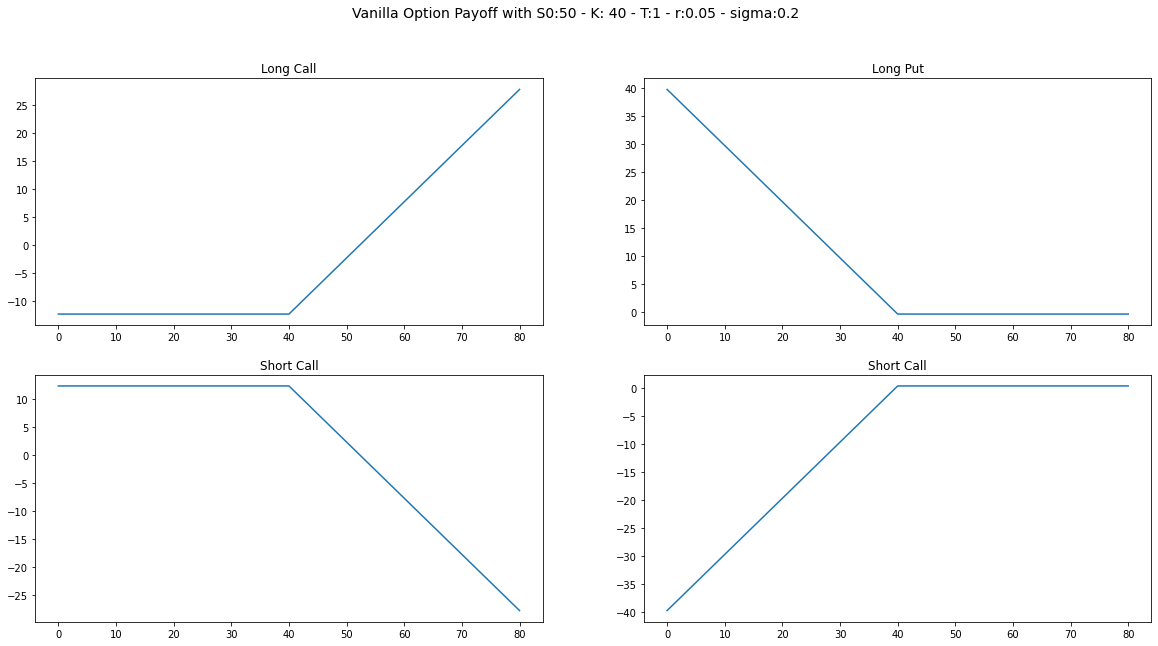

In [9]:
plot_vanilla(arr, market_param)

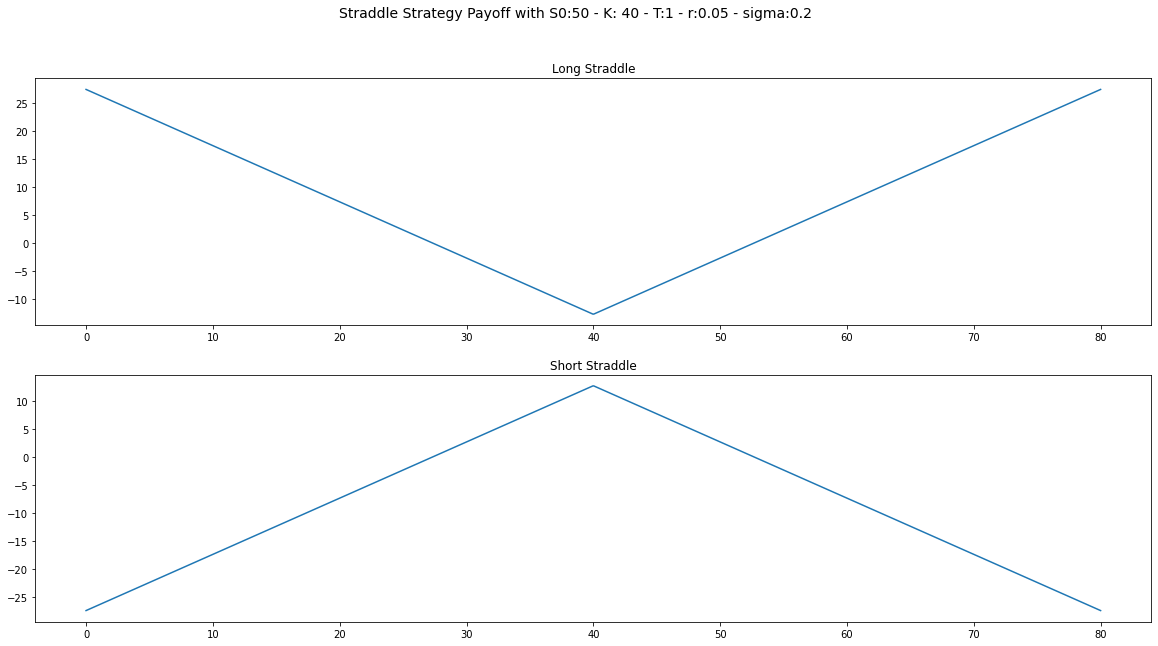

In [10]:
plot_straddle(arr, market_param)

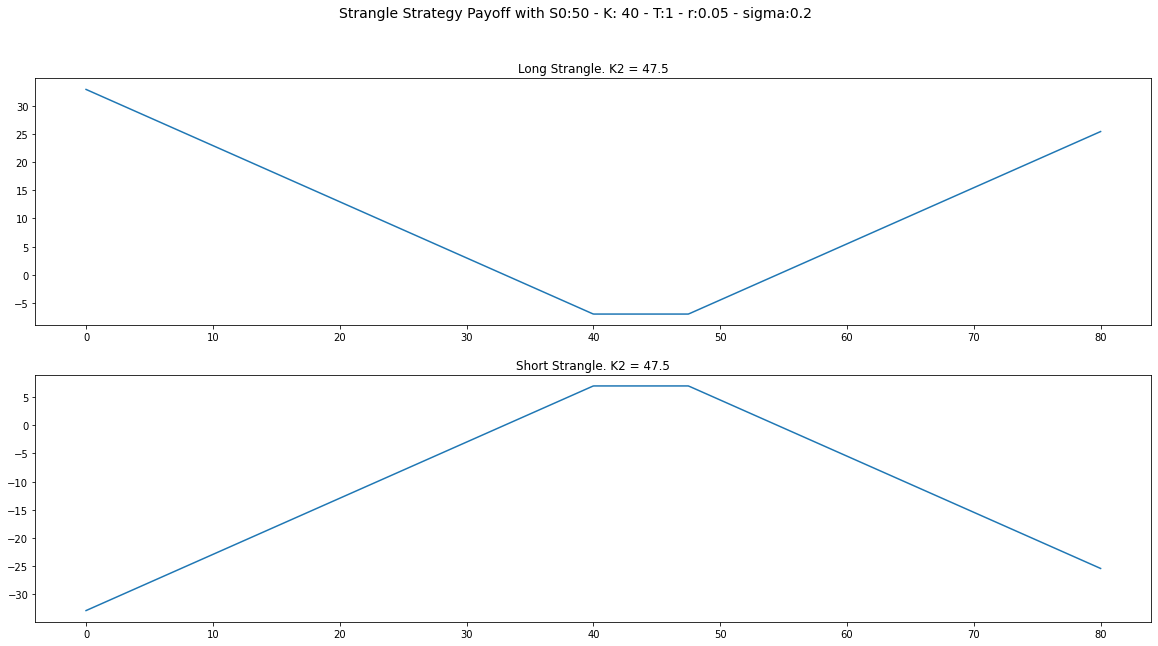

In [11]:
plot_strangle(arr, market_param, market_param2)

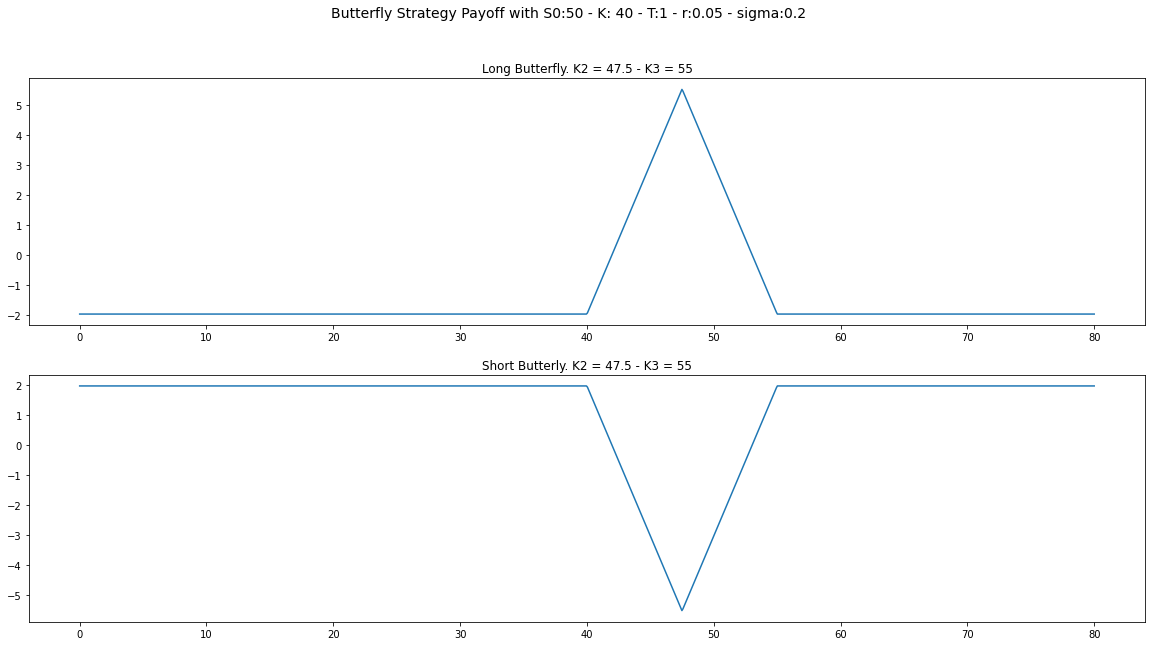

In [12]:
plot_butterfly(arr, market_param, market_param2, market_param5)

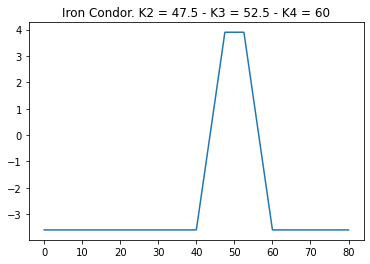

In [13]:
plot_condor(arr, market_param, market_param2, market_param3, market_param4)